Scoring in next 10 actions model - Model Tuning and Building - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from exp_vaep.exp_vaep_config import exp_vaep_modelling_v2_file_path
from exp_vaep.domain.preprocessing.preprocessing import *
# from exp_vaep.domain.contracts.mappings import Mappings
from exp_vaep.domain.contracts.modelling_data_contract import ModellingDataContract
from exp_vaep.domain.modelling.hyperparameter_tuning import XGBHyperparameterTuner
from exp_vaep.domain.modelling.supermodel import SuperXGBRegressor
from exp_vaep.domain.modelling.optuna_xgb_param_grid import OptunaXGBParamGrid

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Model Version

In [3]:
model_version = 2
model_name = 'exp_vaep_conceding'
model_file_name = model_name + '_v' + str(model_version)

model_output_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/models"
prediction_output_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/predictions"

preprocessor_file_name = 'preprocessor_v' + str(model_version)
preprocessor_output_path = ""

In [4]:
RESPONSE = ModellingDataContract.RESPONSE_CONCEDES

In [5]:
FEATURES = ModellingDataContract.feature_list_scores

In [6]:
MONOTONE_CONSTRAINTS = {}

Load Data

In [7]:
df_modelling = pd.read_csv(exp_vaep_modelling_v2_file_path)
df_modelling.tail()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,xScore,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Unconteste

Train Test Split

In [8]:
training_data = df_modelling[df_modelling[RESPONSE+"TrainingSet"]]
test_data = df_modelling[df_modelling[RESPONSE+"TestSet"]]
cal_data = df_modelling[df_modelling[RESPONSE+"ValidationSet"]]

In [9]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [10]:
y_train.mean(), y_test.mean(), y_cal.mean()

(0.16092244226915267, 0.15994488095463613, 0.16182815666297234)

In [11]:
X_test.head()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,xScore,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Unconteste

Preprocess Data

In [12]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train = preprocessor.transform(X_train)
# X_test = preprocessor.transform(X_test)

In [13]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]
X_cal_preproc = X_cal[FEATURES]

In [14]:
X_train_preproc.shape, X_cal_preproc.shape, X_test_preproc.shape

((660577, 220), (165145, 220), (206431, 220))

In [15]:
X_train_preproc.head()

,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Uncontested Mark_a2,type_Contested Mark_a2,type_Loose Ball Get_a2,type_Hard Ball Get_a2,type_Spoil_a2,type_Gather_a2,type_Free For_a2,type_Knock On_a2

In [16]:
X_test_preproc.head()

,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Uncontested Mark_a2,type_Contested Mark_a2,type_Loose Ball Get_a2,type_Hard Ball Get_a2,type_Spoil_a2,type_Gather_a2,type_Free For_a2,type_Knock On_a2

<Axes: >

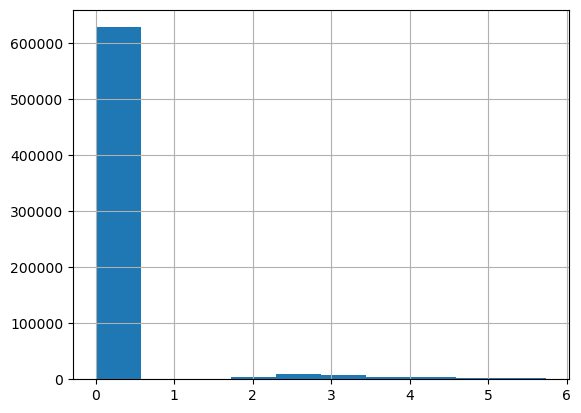

In [17]:
y_train.hist()

Optuna Hyperparameter Tuning Class - HyperParameterTuner & XGBHyperparameterTuner

In [18]:
xgb_tuner = XGBHyperparameterTuner(X_train_preproc, y_train, monotonicity_constraints={})

In [19]:
xgb_tuner.error

'reg:squarederror'

In [20]:
xgb_tuner.tune_hyperparameters()

[I 2023-09-04 14:41:48,733] A new study created in memory with name: no-name-4a718c67-519b-407c-91d7-b50b36748ee7
[I 2023-09-04 14:42:02,634] Trial 0 finished with value: 0.7230764126015189 and parameters: {'max_depth': 4, 'min_child_weight': 86, 'eta': 0.1055708564034597, 'gamma': 0.0014605806804569206, 'lambda': 0.0002698886730075686, 'alpha': 6.533813539600748, 'subsample': 0.6703239164600643, 'colsample_bytree': 0.3289432350650435}. Best is trial 0 with value: 0.7230764126015189.
[I 2023-09-04 14:42:20,122] Trial 1 finished with value: 0.7086184188223124 and parameters: {'max_depth': 9, 'min_child_weight': 30, 'eta': 0.30154546207157534, 'gamma': 0.03496277114036936, 'lambda': 0.08429831296512419, 'alpha': 5.961105740862416, 'subsample': 0.5926718159939086, 'colsample_bytree': 0.44948426389542717}. Best is trial 1 with value: 0.7086184188223124.
[I 2023-09-04 14:42:43,423] Trial 2 finished with value: 0.7186779894113754 and parameters: {'max_depth': 19, 'min_child_weight': 62, 'eta

Number of finished trials:  10
Best trial:
  Value: 0.706902592922119
  Params: 
    max_depth: 11
    min_child_weight: 40
    eta: 0.5221827802165279
    gamma: 6.997366106194309
    lambda: 0.004393626545204638
    alpha: 0.04439118689197286
    subsample: 0.8969992709473311
    colsample_bytree: 0.7023281613962051


In [21]:
params = xgb_tuner.get_best_params()
params

{'max_depth': 11,
 'min_child_weight': 40,
 'eta': 0.5221827802165279,
 'gamma': 6.997366106194309,
 'lambda': 0.004393626545204638,
 'alpha': 0.04439118689197286,
 'subsample': 0.8969992709473311,
 'colsample_bytree': 0.7023281613962051}

Training Model - SuperXGBClassifier class for training and predictions

In [24]:
params['objective'] = OptunaXGBParamGrid.error
params['num_rounds'] = 1000
params['early_stopping_rounds'] = 50
params['verbosity'] = 1
params['monotone_constraints'] = {}

In [23]:
super_xgb = SuperXGBRegressor(X_train = X_train_preproc, 
                               y_train = y_train, 
                               X_test = X_test_preproc, 
                               y_test = y_test,
                               params = params)

In [25]:
super_xgb.fit()

[0]	validation_0-rmse:0.72409	validation_1-rmse:0.72449
[1]	validation_0-rmse:0.69852	validation_1-rmse:0.70338
[2]	validation_0-rmse:0.68915	validation_1-rmse:0.69820
[3]	validation_0-rmse:0.68547	validation_1-rmse:0.69733
[4]	validation_0-rmse:0.68317	validation_1-rmse:0.69755
[5]	validation_0-rmse:0.68253	validation_1-rmse:0.69761
[6]	validation_0-rmse:0.68182	validation_1-rmse:0.69761
[7]	validation_0-rmse:0.68048	validation_1-rmse:0.69755
[8]	validation_0-rmse:0.68007	validation_1-rmse:0.69767
[9]	validation_0-rmse:0.67910	validation_1-rmse:0.69796
[10]	validation_0-rmse:0.67889	validation_1-rmse:0.69803
[11]	validation_0-rmse:0.67816	validation_1-rmse:0.69816
[12]	validation_0-rmse:0.67777	validation_1-rmse:0.69827
[13]	validation_0-rmse:0.67719	validation_1-rmse:0.69842
[14]	validation_0-rmse:0.67707	validation_1-rmse:0.69840
[15]	validation_0-rmse:0.67644	validation_1-rmse:0.69849
[16]	validation_0-rmse:0.67605	validation_1-rmse:0.69871
[17]	validation_0-rmse:0.67564	validation

In [26]:
super_xgb.xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7023281613962051, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=6.997366106194309, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5221827802165279, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=40, missing=nan, monotone_constraints={},
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
super_xgb.xgb_model.get_booster().feature_names

['type_Kick_a0',
 'type_Handball_a0',
 'type_Carry_a0',
 'type_Uncontested Mark_a0',
 'type_Contested Mark_a0',
 'type_Loose Ball Get_a0',
 'type_Hard Ball Get_a0',
 'type_Spoil_a0',
 'type_Gather_a0',
 'type_Free For_a0',
 'type_Knock On_a0',
 'type_Shot_a0',
 'type_Tackle_a0',
 'type_Error_a0',
 'outcome_effective_a0',
 'outcome_ineffective_a0',
 'outcome_clanger_a0',
 'type_Kick_outcome_effective_a0',
 'type_Kick_outcome_ineffective_a0',
 'type_Kick_outcome_clanger_a0',
 'type_Handball_outcome_effective_a0',
 'type_Handball_outcome_ineffective_a0',
 'type_Handball_outcome_clanger_a0',
 'type_Carry_outcome_effective_a0',
 'type_Carry_outcome_ineffective_a0',
 'type_Carry_outcome_clanger_a0',
 'type_Uncontested Mark_outcome_effective_a0',
 'type_Uncontested Mark_outcome_ineffective_a0',
 'type_Uncontested Mark_outcome_clanger_a0',
 'type_Contested Mark_outcome_effective_a0',
 'type_Contested Mark_outcome_ineffective_a0',
 'type_Contested Mark_outcome_clanger_a0',
 'type_Loose Ball Get

In [28]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

Check Average Predictions

In [29]:
train_preds.mean(), y_train.mean()

(0.17866941, 0.16092244226915267)

In [30]:
test_preds.mean(), y_test.mean()

(0.17973705, 0.15994488095463613)

Export model

In [31]:
super_xgb.export_model(model_output_path + "/" + model_file_name + ".joblib")

Export data and predictions

In [32]:
train_export = pd.concat([X_train, y_train], axis=1)
train_export['xgb_preds_'+RESPONSE] = train_preds
train_export.to_csv(prediction_output_path + '/train_predictions_' + model_file_name + '.csv', index = False)
train_export.head()

In [ ]:
test_export = pd.concat([X_test, y_test], axis=1)
test_export['xgb_preds_'+RESPONSE] = test_preds
test_export.to_csv(prediction_output_path + '/test_predictions_' + model_file_name + '.csv', index = False)
test_export.head()

Save preprocessor

In [ ]:
# joblib.dump(preprocessor, preprocessor_output_path + preprocessor_file_name + ".joblib")